In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

In [3]:
df = pd.read_excel('CO2 dataset.xlsx')

In [4]:
df.head()

,Year,CO2
0,1800,0.00568
1,1801,0.00561
2,1802,0.00555
3,1803,0.00548
4,1804,0.00542


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215 entries, 0 to 214
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Year    215 non-null    int64  
 1   CO2     215 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 3.5 KB


In [6]:
df['Year'] = pd.to_datetime(df['Year'], format='%Y')

In [7]:
df.set_index(['Year'], inplace=True)

In [8]:
df.head()

,CO2
Year,
1800-01-01,0.00568
1801-01-01,0.00561
1802-01-01,0.00555
1803-01-01,0.00548
1804-01-01,0.00542


In [9]:
df.index.min(), df.index.max()


(Timestamp('1800-01-01 00:00:00'), Timestamp('2014-01-01 00:00:00'))

In [10]:
if (df.index.max() - df.index.min() == 214):
    print ('Data is Continous')

In [11]:
df.index.freq = 'YS'

<Axes: xlabel='Year'>

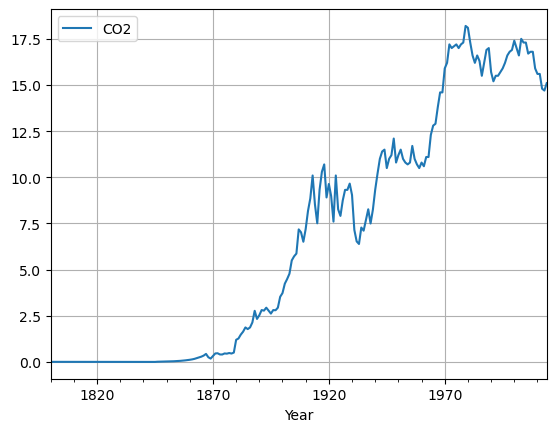

In [12]:
df.plot(grid=True)


In [13]:
train_df = df.loc[:'1991-01-01']
test_df = df.loc['1992-01-01':]

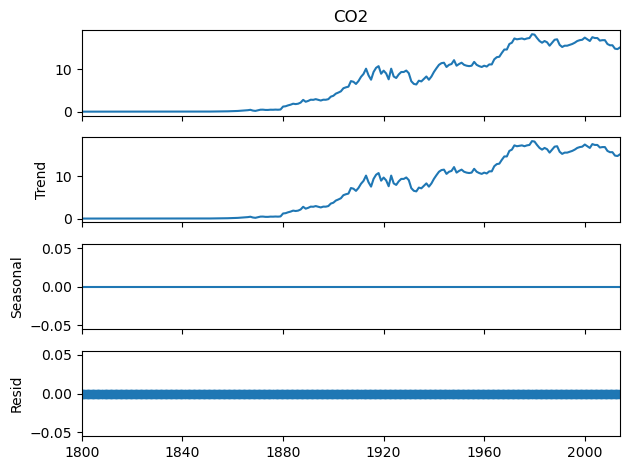

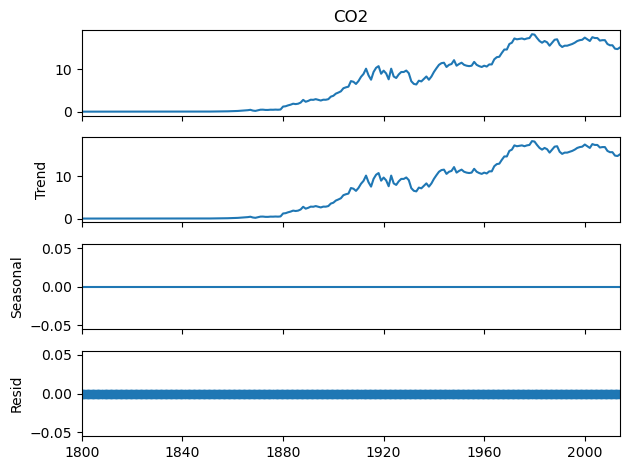

In [14]:
decompose_add = seasonal_decompose(df['CO2'])
decompose_add.plot()

In [15]:
def adf_test(timeseries):
    print ('Hasil testing Dickey-Fuller')
    print ('----------------------------------')
    adftest = adfuller(timeseries)
    adf_output = pd.Series(adftest[0:4], index=['Test statistic','p-value','Lags Used','Number of Observation Used'])
    for key, Value in adftest[4].items() :
        adf_output['Critical Value (%s)' %key] = Value
    print (adf_output)

adf_test(df.values)

Hasil testing Dickey-Fuller
----------------------------------
Test statistic                 -0.378463
p-value                         0.913633
Lags Used                       0.000000
Number of Observation Used    214.000000
Critical Value (1%)            -3.461282
Critical Value (5%)            -2.875143
Critical Value (10%)           -2.574020
dtype: float64


In [16]:
diff_df = df.diff()
diff_df.head()

,CO2
Year,
1800-01-01,NaN
1801-01-01,-0.00007
1802-01-01,-0.00006
1803-01-01,-0.00007
1804-01-01,-0.00006


In [17]:
diff_df.dropna(inplace=True)

<Axes: xlabel='Year'>

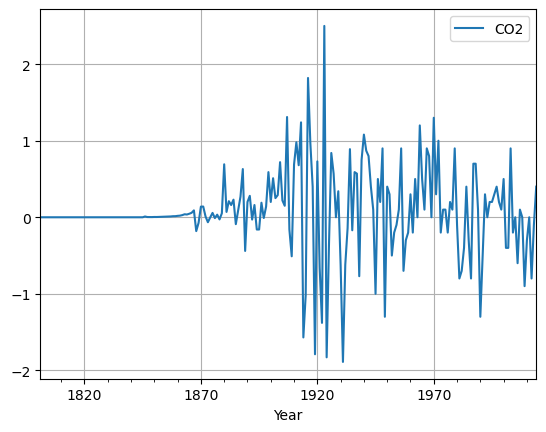

In [18]:
diff_df.plot(grid=True)

In [19]:
adf_test(diff_df)

Hasil testing Dickey-Fuller
----------------------------------
Test statistic                 -3.780005
p-value                         0.003119
Lags Used                      15.000000
Number of Observation Used    198.000000
Critical Value (1%)            -3.463815
Critical Value (5%)            -2.876251
Critical Value (10%)           -2.574611
dtype: float64


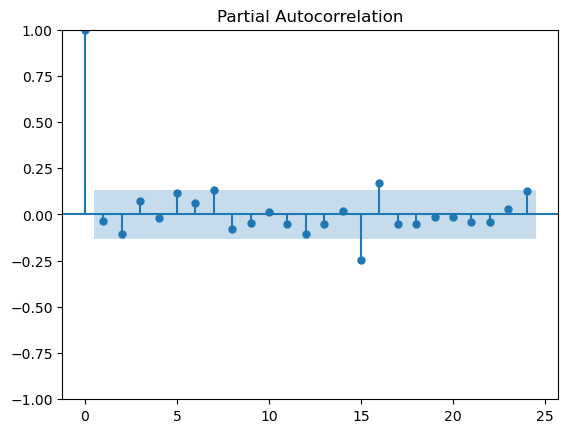

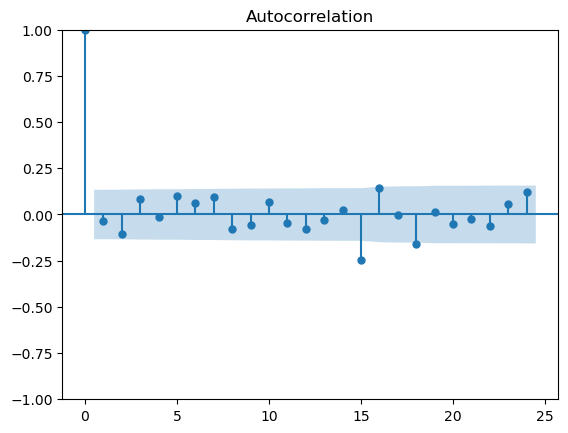

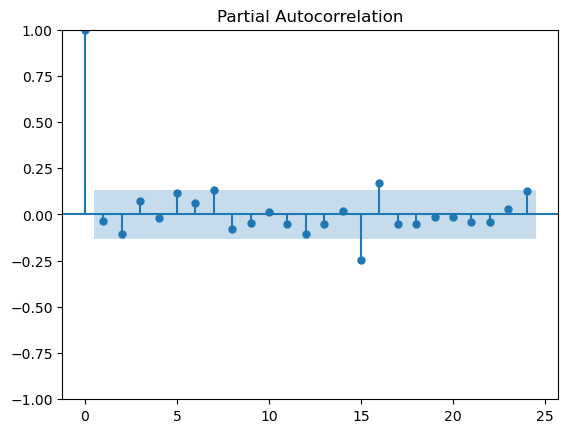

In [20]:
plot_acf(diff_df)
plot_pacf(diff_df)

In [21]:
single_exp = SimpleExpSmoothing(train_df).fit()
single_exp_train_pred = single_exp.fittedvalues
single_exp_test_pred = single_exp.forecast(23)

<Axes: xlabel='Year'>

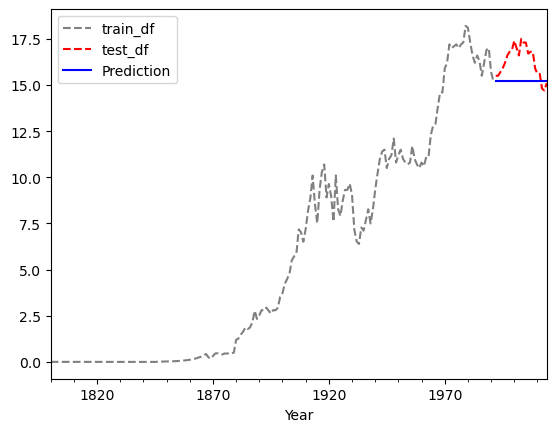

In [22]:
train_df['CO2'].plot(style='--', color='gray', legend=True, label='train_df')
test_df['CO2'].plot(style='--', color='r', legend=True, label='test_df')
single_exp_test_pred.plot(color='b', legend=True, label='Prediction')

In [23]:
print('Train RMSE :',mean_squared_error(train_df, single_exp_train_pred)**0.5)
print('Test RMSE :', mean_squared_error(test_df, single_exp_test_pred)**0.5)
print('Train MAPE :', mean_absolute_percentage_error(train_df, single_exp_train_pred))
print('Test MAPE :', mean_absolute_percentage_error(test_df, single_exp_test_pred))

Train RMSE : 0.5646920026799638
Test RMSE : 1.3429112995695218
Train MAPE : 0.08470457319784763
Test MAPE : 0.06861466396957662


In [24]:
double_exp = ExponentialSmoothing(train_df, trend=None, initialization_method='heuristic', seasonal='add', seasonal_periods=29, damped_trend=False).fit()
double_exp_train_pred = double_exp.fittedvalues
double_exp_test_pred = double_exp.forecast(23)

<Axes: xlabel='Year'>

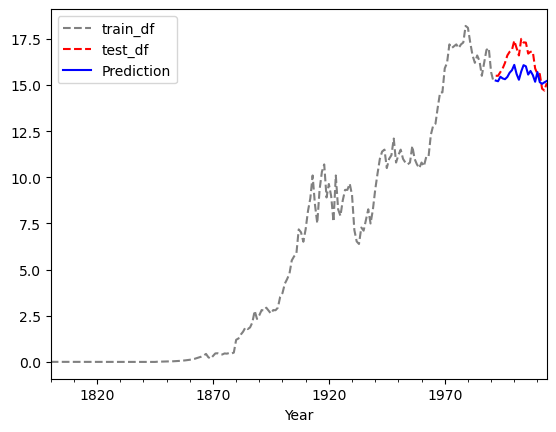

In [25]:
train_df['CO2'].plot(style='--', color='gray', legend=True, label='train_df')
test_df['CO2'].plot(style='--', color='r', legend=True, label='test_df')
double_exp_test_pred.plot(color='b', legend=True, label='Prediction')

In [26]:
print('Train RMSE :',mean_squared_error(train_df, double_exp_train_pred)**0.5)
print('Test RMSE :', mean_squared_error(test_df, double_exp_test_pred)**0.5)
print('Train MAPE :', mean_absolute_percentage_error(train_df, double_exp_train_pred))
print('Test MAPE :', mean_absolute_percentage_error(test_df, double_exp_test_pred))

Train RMSE : 0.5576263311585992
Test RMSE : 0.9739218122258557
Train MAPE : 14.722686127045202
Test MAPE : 0.050781567739945244


In [27]:
ar = ARIMA(train_df, order=(15,1,15)).fit()
ar_train_pred = ar.fittedvalues
ar_test_pred = ar.forecast(23)

d:\Anaconda\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<Axes: xlabel='Year'>

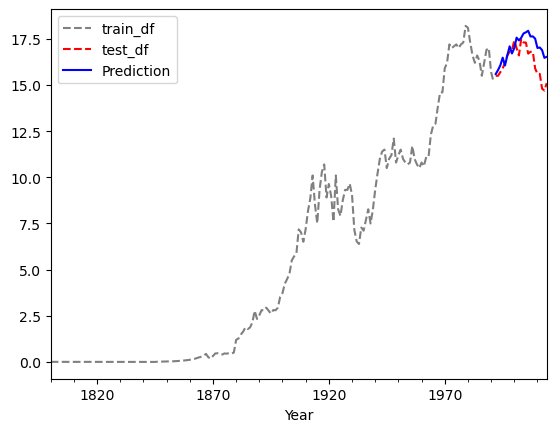

In [28]:
train_df['CO2'].plot(style='--', color='gray', legend=True, label='train_df')
test_df['CO2'].plot(style='--', color='r', legend=True, label='test_df')
ar_test_pred.plot(color='b', legend=True, label='Prediction')

In [29]:
print('Train RMSE :',mean_squared_error(train_df, ar_train_pred)**0.5)
print('Test RMSE :', mean_squared_error(test_df, ar_test_pred)**0.5)
print('Train MAPE :', mean_absolute_percentage_error(train_df, ar_train_pred))
print('Test MAPE :', mean_absolute_percentage_error(test_df, ar_test_pred))

Train RMSE : 0.46786781445564807
Test RMSE : 0.9666496956939578
Train MAPE : 0.08135213595740752
Test MAPE : 0.04808727436661089


In [30]:
comparision_df = pd.DataFrame(data=[
    ['Single Exp Smoothing', 1.3429, 0.0686],
    ['Double Exp Smoothing', 0.5352, 0.0260],
    ['ARIMA', 0.9549, 0.0472]
    ],
    columns=['Model', 'RMSE', 'MAPE'])
comparision_df.set_index('Model', inplace=True)

In [31]:
comparision_df.sort_values(by='RMSE')

,RMSE,MAPE
Model,,
Double Exp Smoothing,0.5352,0.0260
ARIMA,0.9549,0.0472
Single Exp Smoothing,1.3429,0.0686


In [32]:

double_exp = ExponentialSmoothing(df, trend=None, initialization_method='heuristic', seasonal='add', seasonal_periods=29, damped_trend=False).fit()
double_exp_pred = double_exp.forecast(20)

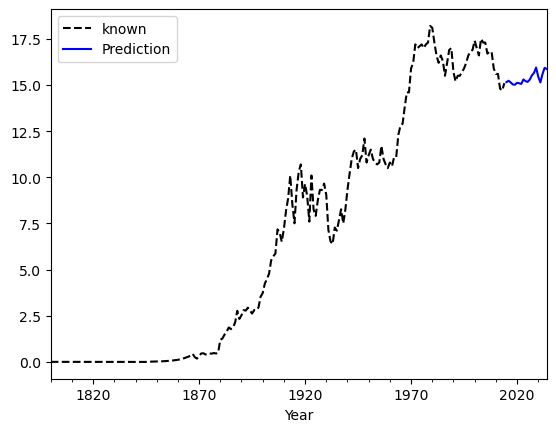

In [ ]:
df['CO2'].plot(style='--', color='black', legend=True, label='known')
double_exp_pred.plot(color='b', legend=True, label='Prediction')
plt.show()

In [38]:
import pickle

In [39]:
pickle.dump(double_exp, open('prediksi_co2.sav','wb'))